In [8]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import csv

class CartPoleEnv_adv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Reward:
        Reward is 1 for every step taken, including the termination step

    Starting State:
        All observations are assigned a uniform random value between ±0.05
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 10
        # 1 0.1 0.5 original
        self.masscart = 1
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 20
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'
		#self.env.spec.max_episode_steps = 200

        # Angle at which to fail the episode
        self.theta_threshold_radians = 20 * 2 * math.pi / 360
        # self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 5
        # self.max_v=1.5
        # self.max_w=1
        # FOR DATA
		
		
        #self.max_v = 50
        self.max_v = np.finfo(np.float32).max
        #self.max_w = 50
        self.max_w = np.finfo(np.float32).max

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([
            self.x_threshold * 2,
            self.max_v,
            self.theta_threshold_radians * 2,
            self.max_w])

        self.action_space = spaces.Box(low=-self.force_mag, high=self.force_mag, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        a = 0
        # self.gravity = np.random.normal(10, 2)
        # self.masscart = np.random.normal(1, 0.2)
        # self.masspole = np.random.normal(0.1, 0.02)
        self.total_mass = (self.masspole + self.masscart)
        state = self.state
        x, x_dot, theta, theta_dot = state
        force = action
        # force = action
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = np.random.normal((force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass,0)
        thetaacc = np.random.normal((self.gravity * sintheta - costheta * temp) / (
                    self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)),0)
        xacc = np.random.normal(temp - self.polemass_length * thetaacc * costheta / self.total_mass,0)
        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            # x_dot = np.clip(x_dot, -self.max_v, self.max_v)
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
            # theta_dot = np.clip(theta_dot, -self.max_w, self.max_w)
        elif self.kinematics_integrator == 'friction':
            xacc = -0.1 * x_dot / self.total_mass + temp - self.polemass_length * thetaacc * costheta / self.total_mass
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            # x_dot = np.clip(x_dot, -self.max_v, self.max_v)
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
            # theta_dot = np.clip(theta_dot, -self.max_w, self.max_w):
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot
        self.state = np.array([x, x_dot, theta, theta_dot])
        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta < -self.theta_threshold_radians \
               or theta > self.theta_threshold_radians
        done = bool(done)
        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return self.state, reward, done, a

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        # self.state[0] = self.np_random.uniform(low=-2, high=2)
        self.steps_beyond_done = None
        return np.array(self.state)

        # self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        # self.steps_beyond_done = None
        # return np.array(self.state)



    def render(self, mode='human'):
        screen_width = 800
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width / world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None: return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
#this is just for showing the shape of membership function. 
# DONT RUN THIS CELL
Angle = ctrl.Antecedent(np.arange(-0.15, 0.15, 0.01), 'Angle')
Angle['vlow'] = fuzz.trapmf(Angle.universe, [-0.15, -0.15, -0.1, -0.075])
Angle['low'] = fuzz.trimf(Angle.universe, [-0.1, -0.075, -0.05])
Angle['slow'] = fuzz.trimf(Angle.universe, [-0.075, -0.05, -0.025])
Angle['avg'] = fuzz.trimf(Angle.universe, [-0.025, 0, 0.025])
Angle['shigh'] = fuzz.trimf(Angle.universe, [0, 0.025, 0.05])
Angle['high'] = fuzz.trimf(Angle.universe, [0.025, 0.05, 0.075])
Angle['vhigh'] = fuzz.trapmf(Angle.universe, [0.075, 0.1, 0.15, 0.15])
Angle.view()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


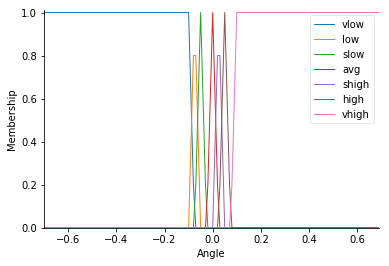

In [3]:
# RUN THIS CELL FOR ANGLE
Angle = ctrl.Antecedent(np.arange(-0.7, 0.7, 0.01), 'Angle')
Angle['vlow'] = fuzz.trapmf(Angle.universe, [-0.7, -0.7, -0.1, -0.075])
Angle['low'] = fuzz.trimf(Angle.universe, [-0.1, -0.075, -0.05])
Angle['slow'] = fuzz.trimf(Angle.universe, [-0.075, -0.05, -0.025])
Angle['avg'] = fuzz.trimf(Angle.universe, [-0.025, 0, 0.025])
Angle['shigh'] = fuzz.trimf(Angle.universe, [0, 0.025, 0.05])
Angle['high'] = fuzz.trimf(Angle.universe, [0.025, 0.05, 0.075])
Angle['vhigh'] = fuzz.trapmf(Angle.universe, [0.075, 0.1, 0.7, 0.7])
Angle.view()

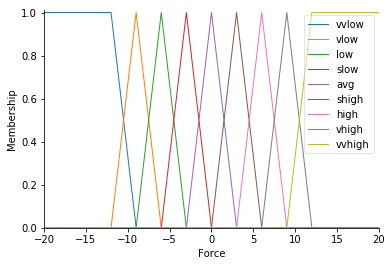

In [4]:
Force = ctrl.Consequent(np.arange(-20, 21, 1), 'Force')
Force['vvlow'] = fuzz.trapmf(Force.universe, [-20, -20, -12, -9])
Force['vlow'] = fuzz.trimf(Force.universe, [-12, -9, -6])
Force['low'] = fuzz.trimf(Force.universe, [-9, -6, -3])
Force['slow'] = fuzz.trimf(Force.universe, [-6, -3, 0])
Force['avg'] = fuzz.trimf(Force.universe, [-3, 0, 3])
Force['shigh'] = fuzz.trimf(Force.universe, [0, 3, 6])
Force['high'] = fuzz.trimf(Force.universe, [3, 6, 9])
Force['vhigh'] = fuzz.trimf(Force.universe, [6, 9, 12])
Force['vvhigh'] = fuzz.trapmf(Force.universe, [9, 12, 20, 20])
Force.view()

In [5]:
rule1 = ctrl.Rule(Angle['vhigh'], Force['high'])
rule2 = ctrl.Rule(Angle['high'], Force['shigh'])
rule3 = ctrl.Rule(Angle['shigh'], Force['avg'])
rule4 = ctrl.Rule(Angle['avg'], Force['avg'])
rule5 = ctrl.Rule(Angle['slow'], Force['avg'])
rule6 = ctrl.Rule(Angle['low'], Force['slow'])
rule7 = ctrl.Rule(Angle['vlow'], Force['low'])


In [6]:
Forcing_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
Forcing = ctrl.ControlSystemSimulation(Forcing_ctrl)

In [13]:
import gym
MAX_EPISODES = 20
MAX_EPISODE_STEPS = 200
sum_f = 0
env = CartPoleEnv_adv()
for i_episode in range(MAX_EPISODES):
    observation = env.reset()
    for timestep in range(MAX_EPISODE_STEPS):
        env.render()
        angl = 0
        vel = 0
        if isinstance(observation[2], np.ndarray):
            angl =  observation[2][0]
        else:
            angl =  observation[2]
            
        if isinstance(observation[3], np.ndarray):
            vel =  observation[3][0]
        else:
            vel =  observation[3]
        Forcing.input['Angle'] = angl
        Forcing.compute()
        action = Forcing.output['Force']
        observation, reward, done, info = env.step(action)
        if done:
            print("in episode :" + str(i_episode) + " finished at : ", str(timestep+1))
            sum_f += (timestep + 1)
            break
            
    else:
        print("in episode :" + str(i_episode) + " finished without fall at : ", str(timestep+1))
        sum_f += (timestep + 1)
            

            
env.close()
print("average of timesteps : ", str(int(sum_f / MAX_EPISODES)))


in episode :0 finished without fall at :  200
in episode :1 finished at :  177
in episode :2 finished without fall at :  200
in episode :3 finished without fall at :  200
in episode :4 finished without fall at :  200
in episode :5 finished at :  176
in episode :6 finished without fall at :  200
in episode :7 finished without fall at :  200
in episode :8 finished at :  181
in episode :9 finished without fall at :  200
in episode :10 finished without fall at :  200
in episode :11 finished without fall at :  200
in episode :12 finished without fall at :  200
in episode :13 finished without fall at :  200
in episode :14 finished without fall at :  200
in episode :15 finished without fall at :  200
in episode :16 finished without fall at :  200
in episode :17 finished at :  179
in episode :18 finished without fall at :  200
in episode :19 finished without fall at :  200
average of timesteps :  195


In [12]:
import gym
MAX_EPISODES = 20
MAX_EPISODE_STEPS = 200
sum_f = 0
env = CartPoleEnv_adv()
for i_episode in range(MAX_EPISODES):
    observation = env.reset()
    for timestep in range(MAX_EPISODE_STEPS):
        env.render()
        angl = 0
        vel = 0
        if isinstance(observation[2], np.ndarray):
            angl =  observation[2][0]
        else:
            angl =  observation[2]
            
        if isinstance(observation[3], np.ndarray):
            vel =  observation[3][0]
        else:
            vel =  observation[3]
        Forcing.input['Angle'] = angl
        Forcing.compute()
        action = Forcing.output['Force']
        observation, reward, done, info = env.step(action)
        if done:
            print("in episode :" + str(i_episode) + " finished at : ", str(timestep+1))
            sum_f += (timestep + 1)
            break
            
    else:
        print("in episode :" + str(i_episode) + " finished without fall at : ", str(timestep+1))
        sum_f += (timestep + 1)
            

            
env.close()
print("average of timesteps : ", str(int(sum_f / MAX_EPISODES)))

in episode :0 finished without fall at :  200
in episode :1 finished without fall at :  200
in episode :2 finished without fall at :  200
in episode :3 finished without fall at :  200
in episode :4 finished without fall at :  200
in episode :5 finished without fall at :  200
in episode :6 finished without fall at :  200
in episode :7 finished without fall at :  200
in episode :8 finished without fall at :  200
in episode :9 finished without fall at :  200
in episode :10 finished without fall at :  200
in episode :11 finished without fall at :  200
in episode :12 finished without fall at :  200
in episode :13 finished without fall at :  200
in episode :14 finished without fall at :  200
in episode :15 finished without fall at :  200
in episode :16 finished without fall at :  200
in episode :17 finished without fall at :  200
in episode :18 finished without fall at :  200
in episode :19 finished without fall at :  200
average of timesteps :  200
